In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [ ]:
from scipy.io import loadmat

## 0.- Function definitions

#### Preprocessing functions

In [ ]:

def background_subtraction(ST_T_ComplexTensor, WindSize):
    """
    This function performs the background subtraction of consecutive ST-T complexes.

    Parameters:
        ST_T_ComplexTensor (array): Tensor with windowed ST-T complexes. (3D array)
        WindSize (int): Size of the sliding window.

    Returns:
        ST_T_TensorBacGrElim (array): Tensor of windowed ST-T complexes after background subtraction.
    """

    ST_T_TensorBacGrElim = np.zeros_like(ST_T_ComplexTensor)

    X = ST_T_ComplexTensor.copy()

    A_pattern = X[0::2, :]
    A_pattern_dis = np.zeros_like(A_pattern)
    A_pattern_dis[0:-1, :] = A_pattern[1:, :]
    A_pattern_dis[-1, :] = A_pattern[WindSize // 2 - 1, :]
    B_pattern = X[1::2, :]
    X[0::2, :] = X[0::2, :] - B_pattern
    X[1::2, :] = X[1::2, :] - A_pattern_dis
    ST_T_TensorBacGrElim = X

    return ST_T_TensorBacGrElim



In [ ]:
from scipy.interpolate import splev, splrep


def bw_elimination(orig_ecg, fiducial_points, fs):
  """
  This function produces an estimate of the baseline wander using polynomial fitting by cubic splines.

  Parameters:
      orig_ecg (array): Samples of the original ECG.
      fiducial_points (array): Fiducial points.
      fs (float): Sampling frequency.

  Returns:
      bw_estimate (array): Baseline wander estimate.
  """

  tPQ = 80e-3  # We take a representative sample of the isoelectric line 80 ms before the fiducial point.
  nPQ = int(tPQ * fs)

  numb_fid_points = len(fiducial_points)
  if fiducial_points[0].any() - nPQ <= 0:
      the_knots = np.array(np.zeros(numb_fid_points+1))
      the_knots[0] = 1
      the_knots[1:numb_fid_points] = fiducial_points[1:numb_fid_points] - nPQ
      the_knots[numb_fid_points] = len(orig_ecg)
      the_knots=the_knots-1
      the_knots=the_knots.astype(int)
      c =np.concatenate((the_knots[1],the_knots[1:numb_fid_points],the_knots[numb_fid_points-1]),axis=None)

      bw_estimate = splev(np.arange(len(orig_ecg)), splrep(the_knots,orig_ecg[c]), ext=0)


  else:
      the_knots = np.array(np.zeros(numb_fid_points + 2))
      the_knots[1:numb_fid_points] = fiducial_points - nPQ
      the_knots[0] = 1
      the_knots[numb_fid_points] = len(orig_ecg)
      the_knots=the_knots-1
      the_knots=the_knots.astype(int)
      c =np.concatenate((the_knots[1],the_knots[1:numb_fid_points],the_knots[numb_fid_points-1]),axis=None)
      bw_estimate = splev(np.arange(len(orig_ecg)), splrep(the_knots,c), ext=0)


  return bw_estimate

In [ ]:
from scipy.signal import kaiserord, firwin, lfilter
import numpy as np

def filtering_ST_T_segments(ST_T_ComplexTensor, Fs):
    """
    This function filters out the ST-T complexes to eliminate noise outside the TWA band (0.3-15 Hz).

    Parameters:
        ST_T_ComplexTensor (array): Tensor with windowed ST-T complexes.
        Fs (float): Working sampling frequency.

    Returns:
        ST_T_TensorFiltered (array): Tensor of windowed ST-T complexes after filtering.
    """

    # Design the filter
    nyquist = 0.5 * Fs
    passband_low = 0.3
    passband_high = 15.0
    ripple_db = 0.01
    ripple = 80.0

    # obtain numtaps and beta using kaiserord
    numtaps, beta = kaiserord(ripple, (passband_high - passband_low) / nyquist)

    # Compute the normalized cutoff frequencies
    cutoff_low = passband_low / nyquist
    cutoff_high = passband_high / nyquist

    # Compute the filter coefficients using firwin
    b = firwin(numtaps, [cutoff_low, cutoff_high], window=('kaiser', beta), pass_zero=False, scale=False)
    delay = int((numtaps + 1) / 2)
    b_wide = b

    ST_T_TensorFiltered = np.zeros_like(ST_T_ComplexTensor)  # Initialize the filtered tensor

    # Iterate over segments, windows, and ST-T samples
    for k1 in range(ST_T_ComplexTensor.shape[2]):
        for k2 in range(ST_T_ComplexTensor.shape[0]):
            # Apply filtering to each window
            filtered_wide = lfilter(b_wide, 1, np.concatenate((ST_T_ComplexTensor[k2, :, k1], np.zeros(delay))))
            ST_T_TensorFiltered[k2, :, k1] = filtered_wide[delay:ST_T_ComplexTensor.shape[1] + delay]

    return ST_T_TensorFiltered


In [ ]:
def heartbeat_windowing(ST_T_complexes, ST_T_onset, WindSize, WindStep):
    """
    This function performs windowing to track alternans in an ECG.

    Parameters:
        ST_T_complexes (array): 2D matrix of ST-T segments of the signal.
        ST_T_onset (array): Onset of the ST-T segments.
        WindSize (int): Window length in beats.
        WindStep (int): Step size of the sliding process.

    Returns:
        ST_T_segments (array): Tensor with windowed ST-T complexes.
        ST_T_onset_by_segments (array): ST-T onset of the tensor.
        ST_T_dim (tuple): Dimensions of the incoming matrix of ST-T complexes.
    """

    Overlap = WindSize - WindStep
    ST_T_dim = np.shape(ST_T_complexes)

    NumbSegments = int((ST_T_dim[0] - Overlap) / WindStep)


    # Adjust the number of segments if necessary
    if NumbSegments == np.ceil((ST_T_dim[0] - Overlap) / WindStep):
        NumbSegments = NumbSegments - 1


    ST_T_segments = np.zeros((WindSize, ST_T_dim[1], NumbSegments))  # Tensor to store windowed ST-T complexes
    ST_T_onset_by_segments = np.zeros((NumbSegments, WindSize))  # ST-T onset of the tensor


    index1 = 0
    index2 = WindSize

    # Perform windowing
    for k in range(NumbSegments):
        ST_T_segments[:,:,k] = ST_T_complexes[index1:index2,:]

        ST_T_onset_by_segments[k,:] = ST_T_onset[index1:index2]
        index1 = index1 + WindStep
        index2 = index2 + WindStep

    return ST_T_segments, ST_T_onset_by_segments, ST_T_dim

In [ ]:
def np_round(a, decimals=0):
    return np.round(a * 10 ** decimals) / 10 ** decimals


def ST_T_alignment(ST_T_complexes, ST_T_onset, ecg_signal, fs):

    nbeats, nsamples = ST_T_complexes.shape
    ST_T_complexes_align = np.zeros(ST_T_complexes.shape)
    # Median template
    proto = np.median(ST_T_complexes, axis=0)
    # Possible temporal variation from the initial position of each ST_T complex
    w =(0.03 * fs)  # samples
    w = np_round(w)
    w= int(w)

    for k in range(nbeats):
        ini = int(ST_T_onset[k])
        fin = int(ini + nsamples - 1)

        ecg_segment = ecg_signal[ini - w:fin + w]
        cross_corr = np.zeros(2 * w)

        for m in range(2 * w):
            temp = ecg_segment[m:-(2 * w) + m] #[m:fin-(2*w)+m-1]
            # Ajustar la dimensión de temp
            if temp.shape[0] < proto.shape[0]:
                temp = np.append(temp, temp[-1])
            cc = np.corrcoef(proto, temp)
            cross_corr[m] = cc[1, 0]

        posMax = np.argmax(cross_corr)
        ST_T_complexes_align[k, :] = ecg_segment[posMax:posMax + nsamples]    #[posMax:fin-(2*w)+posMax-1]

    return ST_T_complexes_align

In [ ]:
def ST_T_delineation(ecg_signal, fiducial_points, fs):
    """
    This function delineates the ST-T complex using intervals of 300 ms length.
    The ST-T onset is chosen to be a variable distance from the QRS point that
    depends on the previous RR interval length.

    Parameters:
        ecg_signal (array): ECG signal.
        fiducial_points (array): R wave annotations.
        fs (float): Sampling frequency.

    Returns:
        ST_T_complexes (array): Matrix of ST-T complexes.
        ST_T_onset (array): Array of annotations of ST-T onset values.
    """
    RR_interval = np.diff(fiducial_points) / fs  # RR interval in seconds
    qi = 40 + (1.3 * np.sqrt(RR_interval * 1e3))  # ST-T onset from R in milliseconds

    if qi.ndim == 1:
        qi = np.column_stack((qi[0], qi[:-1]))
    else:
        qi = np.column_stack((qi[:, 0], qi[:, :-1]))
    s = np.array(qi * 1e-3 * fs)
    fiducial_points = fiducial_points.transpose()


    ST_T_onset = fiducial_points + np.ceil(s) + 1  # ST-T onset in samples

# para que no sea una lista con matrices con el mismo numero repetido
    ST_T_onset = [matriz[0] for matriz in ST_T_onset]

    ST_T_interval = np.ceil(300e-3 * fs)  # ST-T interval length in number of samples

    ST_T_complexes = np.zeros((len(ST_T_onset)-1, int(ST_T_interval)))
    last_beat = ST_T_onset[-1]

    #La variable onset representa el inicio de cada segmento y la variable interval representa la duración de cada segmento
    number_of_ST_T = len(ST_T_onset)
    for k in range(number_of_ST_T):
        onset = int(np.ceil(ST_T_onset[k]))
        interval = onset + ST_T_interval

        if interval <= len(ecg_signal):
            ST_T_complexes[k, :] = ecg_signal[int(onset):int(interval)]

    return ST_T_complexes, ST_T_onset


#### Add alternans function

In [ ]:
def include_TWA(clean_ecg, ST_T_onset, Alternan_wave, TWA_pattern, Type_of_inclusion):
    """
    The purpose of this function is the inclusion of an alternan wave into an ECG signal.

    Parameters:
        clean_ecg (numpy array): Array of integers corresponding to the ECG signal.
        ST_T_onset (numpy array): Array of annotations of ST-T onset values.
        Alternan_wave (numpy array): Waveform to perform TWA.
        TWA_pattern (numpy array): Array that describes the intervals where TWA are included.
        Type_of_inclusion (str): If this string is 'alternate', the alternan wave is included in every other beats with opposite sign.
                                 Otherwise, the alternan wave is only included every two beats.

    Returns:
        ecg_with_TWA (numpy array): ECG with TWA.
        Alt_waves (numpy array): Matrix whose rows consist of the alternan waves of ecg_with_TWA. It is subsequently used to compute the ANR.
    """

    # Get the length of the Alternan wave
    L_AltWav = len(Alternan_wave)

    # Create a copy of the clean ECG signal
    ecg_with_TWA = clean_ecg.copy()

    # Initialize the Alt_waves matrix
    Alt_waves = np.zeros((len(ST_T_onset), L_AltWav))

    if Type_of_inclusion.lower() == 'alternate':
        # Include alternan wave in every other beat with opposite sign
        for k, onset in enumerate(ST_T_onset):
            if onset + L_AltWav <= (clean_ecg.shape[1]):
                Alt_waves[k, :] = TWA_pattern[k] * Alternan_wave * (-1) ** k
                #plt.plot(ecg_with_TWA[0, onset:onset + L_AltWav])
                ecg_with_TWA[0, onset:onset + L_AltWav] += Alt_waves[k, :]
                #plt.plot(ecg_with_TWA[0, onset:onset + L_AltWav])
                #plt.show()


    else:
        # Include alternan wave every two beats
        for k, onset in enumerate(ST_T_onset[1::2]):
            if onset + L_AltWav <= (clean_ecg.shape[1]):
                Alt_waves[k, :] = TWA_pattern[2 * k] * Alternan_wave
                ecg_with_TWA[0, onset:onset + L_AltWav] += Alt_waves[k, :]
    return ecg_with_TWA, Alt_waves


In [ ]:
import numpy as np

def alternant_wave_inclusion(clean_ecg, TWA_pattern, type_of_inclusion, ST_T_onset, V_Alt_wave, Fs):
    """
    This function introduces an alternant wave according to the pattern
    defined by 'TWA_pattern' in the signal 'clean_ecg'.

    Input parameters:
        - clean_ecg: annotations of the R wave.
        - TWA_pattern: TWA pattern vector.
        - type_of_inclusion: manner TWA is included; can be 'alternate' or not.
        - ST_T_onset: onset of ST-T complexes of the ECG.
        - V_Alt_wave: alternant voltage.
        - Fs: sampling frequency

    Output parameters:
        - ecg_with_TWA: ECG signal with alternans.
        - Alt_waves: matrix whose rows consist of the alternan wave ecg_with_TWA.
        - Alternan_wave: waveform to perform TWA.
        - Onset_Valt: onset of TWA inclusion, having considered Jitter effect.

        _____________________________________
       |                                     |
       |  Manuel Blanco Velasco: 2023/03/06  |
       |_____________________________________|

    """

    # Load the MATLAB file
    mat_data = scipy.io.loadmat('AltWav_128hz.mat')

    AltWav = np.random.randint(1, 16)

    # Access the desired key
    Alternan_wave = mat_data['AltWav_128hz'][:, AltWav - 1]

    if type_of_inclusion.lower() == 'alternate':
        alpha = V_Alt_wave / (np.max(np.abs(2 * Alternan_wave)) * 1e3)
    else:
        alpha = V_Alt_wave / (np.max(np.abs(Alternan_wave)) * 1e3)

    jitter_std = int(0.02 * Fs)  # Jitter effect standard deviation of 20 ms (0.02*Fs samples)

    Onset_Valt = (ST_T_onset + np.round(np.random.randn(len(ST_T_onset)) * jitter_std)).astype(int)

    #Onset_Valt = ST_T_onset + np.round(np.random.normal(0, jitter_std, size=len(ST_T_onset))).astype(int)

    ecg_with_TWA, Alt_waves = include_TWA(clean_ecg, Onset_Valt, alpha * Alternan_wave, TWA_pattern, type_of_inclusion)

    V0 = np.max(np.abs(alpha * Alternan_wave)) * 1e3  # Alternan wave amplitude in microvolts
    if type_of_inclusion.lower() == 'alternate':
        V0 = 2 * V0

    return ecg_with_TWA, Alt_waves, Alternan_wave, alpha, Onset_Valt

#### Methods function

In [ ]:
import numpy as np

def SM_TWA(M_Wind):
    """
    This function applies the enhanced spectral method (SM) explained in:

    MG Fernández-Calvillo et all, "Machine Learning approach for TWA detection relying on ensemble data design," Heliyon, Vol. 9, no. 1, Jan 2023.

    The method can work over either ST-T complexes or differential ST-T complexes. The SM estimates the power spectrum density of each beat
    series Sj by means of the periodogram:

             Pj=(1/M)|FFT({Sj})|^2

    where M stands for the number of heartbeats taken to apply the SM. The averaged power spectrum of the all beat series is:

                 P=(1/N)?Pj

    Parameters:
        M_Wind (array): Array containing the signal corresponding to one window.

    Returns:
        AverPSD (array): Averaged spectrum.
        K_score (float): TWAR value.
        Valt (float): Estimated alternant wave.
    """

    M = len(M_Wind['0'])
    N = len(M_Wind['0'][0])

    L = 2 ** np.ceil(np.log2(M))  # Resolution of the FFT.


    PSD_BeatSeries = np.abs(np.fft.fft(M_Wind['0'], L, axis=0)) ** 2
    AverPSD = np.mean(PSD_BeatSeries, axis=1) / (M * N)

    noise_band = AverPSD[int(0.66 * ((L / 2)-1)):int(0.96 * ((L / 2)-1))]


    noise_mean = np.mean(noise_band)

    noise_std = np.std(noise_band)

    T = AverPSD[1 + int(((L / 2)-1))]

    K_score = (T - noise_mean) / noise_std

    if K_score > 0:
        Valt = np.sqrt(T - noise_mean) / np.sqrt(M)  # The division by sqrt(M) is to compensate a weighting factor.
    else:
        Valt = 0



    return AverPSD, K_score, Valt


In [ ]:
import numpy as np

def TimeMethod_TWA(M_Wind):
    """
    This function applies the Time Method to detect TWA, as reported in:

    MG Fernández-Calvillo et all, "Machine Learning approach for TW detection relying on ensemble data design," Heliyon, Vol.9, No. 1, Jan 2023.

    Parameters:
        M_Wind (array): Array containing the signal corresponding to one window of ST-ST complexes.

    Returns:
        Valt_est (float): Estimated TWA voltage (in microV).
        Valt_wave_est (array): ML estimate of the alternant wave (in microV).
    """

    M_Wind = np.array(M_Wind)  # Convert the list to a NumPy array


    Valt_wave_est = np.mean(M_Wind[::2, :], axis=0) - np.mean(M_Wind[1::2, :], axis=0)
    Valt_est = np.max(np.abs(Valt_wave_est)) * 0.5 * 1e3

    return Valt_est, Valt_wave_est

## 1.- Analysis System

###Create a list from all of the signals

In [ ]:
import os
import json
from google.colab import drive
from scipy.io import loadmat

from google.colab import drive
from scipy.io import loadmat

from google.colab import drive
drive.mount('/content/drive')
ruta_archivo = "/content/drive/MyDrive/35muV_filtered_signals.json"
with open(ruta_archivo, "r") as archivo:
    all_filtered = json.load(archivo)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(all_filtered.keys())

dict_keys(['Señales_sin_alternancias_nsrdb_16483_l1_s45.mat', 'Señales_sin_alternancias_nsrdb_16265_l2_s9.mat', 'Señales_sin_alternancias_nsrdb_16539_l2_s16.mat', 'Señales_sin_alternancias_nsrdb_16483_l1_s37.mat', 'Señales_sin_alternancias_nsrdb_16273_l2_s6.mat', 'Señales_sin_alternancias_nsrdb_16483_l1_s46.mat', 'Señales_sin_alternancias_nsrdb_16483_l1_s25.mat', 'Señales_sin_alternancias_nsrdb_16483_l2_s7.mat', 'Señales_sin_alternancias_nsrdb_16483_l1_s33.mat', 'Señales_sin_alternancias_nsrdb_16420_l1_s19.mat', 'Señales_sin_alternancias_nsrdb_16539_l1_s42.mat', 'Señales_sin_alternancias_nsrdb_16539_l1_s19.mat', 'Señales_sin_alternancias_nsrdb_16420_l2_s10.mat', 'Señales_sin_alternancias_nsrdb_16539_l1_s7.mat', 'Señales_sin_alternancias_nsrdb_16265_l1_s34.mat', 'Señales_sin_alternancias_nsrdb_16539_l2_s23.mat', 'Señales_sin_alternancias_nsrdb_16420_l1_s21.mat', 'Señales_sin_alternancias_nsrdb_16539_l2_s9.mat', 'Señales_sin_alternancias_nsrdb_16539_l1_s2.mat', 'Señal

In [ ]:
'''
print(all_filtered['Señales_sin_alternancias_nsrdb_16420_l1_s3.mat']['0'])
plt.plot(np.transpose(all_filtered['Señales_sin_alternancias_nsrdb_16420_l1_s3.mat']['0']))
plt.show()
'''

"\nprint(all_filtered['Señales_sin_alternancias_nsrdb_16420_l1_s3.mat']['0'])\nplt.plot(np.transpose(all_filtered['Señales_sin_alternancias_nsrdb_16420_l1_s3.mat']['0']))\nplt.show()\n"

## 2.- Spectral Method

The Spectral method is a commonly used technique for T-wave alternans (TWA) detection. It analyzes the spectral characteristics of the ECG signal to identify the presence of alternans. Here's an overview of the SM procedure:

1. Compute the power spectral density (PSD) of the modified signal.
2. Analyze the spectral components in specific frequency bands associated with alternans.
3. Apply a thresholding technique to determine the presence or absence of alternans based on the spectral characteristics.

### Step 1: Spectral Method - Calculate K-score for each signal

`K_score` is a variable representing the TWAR (T-Wave Alternans Ratio) values obtained from the Spectral Method. It is a measure used to quantify the presence of T-wave alternans in the ECG signal. The value of `K_score` is calculated based on the power spectrum density estimation and the noise characteristics of the signal.

The specific value of `K_score` indicates the significance of T-wave alternans in the analyzed segment. A higher `K_score` suggests a stronger presence of alternans, while a lower value indicates a weaker or negligible alternans. The threshold for determining the presence of alternans may vary depending on the specific application or criteria defined by the researcher.


---

The $V_{alt}$ measured in $\mu$V, represents the square root of alternans power, which is defined as the difference between the power at the alternans frequency (0.5 cycles/beat) and the power at the noise frequency (0.44 and 0.49 cycles/beat). And also, it corresponds to the root mean square difference in the voltage between the overall mean beat and either the odd- numbered or even- numbered beats.

In [ ]:

# Create list to store K-scores
K_scores = np.zeros(len(all_filtered))

# Perform analysis
for i, signal in enumerate(all_filtered.values()):
    AverPSD, k_score, _ = SM_TWA(signal)

    # Store K-score for each signal in list
    K_scores[i] = k_score

len(K_scores)

206

In [ ]:
print(K_scores)

[ 2.76393687e-01  4.59299882e+00  4.35303288e+01  6.49453433e+00
  5.25905997e+00  4.95587351e+00  3.50301158e+00  1.41304139e+01
  1.00156403e+01  2.25114188e+00  2.14717734e+01 -1.15848199e+00
  1.52472746e+01  9.20055227e+00  6.70860939e+00  4.62653998e+01
 -1.74981322e+00  6.71347927e+00  3.44339283e+00  1.42301524e+01
  1.48472619e+01 -2.05851062e-01 -5.67002980e-01  1.91458839e+00
  5.30836776e+00 -9.46913091e-01  9.33866338e+00  2.74212965e+01
  2.52416699e+00  4.16556783e+01  4.02536583e-01  2.84619196e+01
  4.85125539e+01  1.19344576e+00  2.13167857e+01  6.75169436e+00
  5.33581638e+01  2.16393998e+00  1.42757391e+01 -1.79973654e-01
 -7.83821823e-01  8.66791699e+00  1.27066804e+00  4.10759916e+00
  3.46965371e+01  2.52268296e+01  8.37966057e+00  1.92157043e+01
  5.67760665e+00  2.36667896e+01  2.70956789e-01  2.81328051e+01
  4.78277662e+00  4.48217226e+01  6.29756918e+01  6.36680204e+00
  3.82466807e+01  1.78655973e+00  1.49396912e+01  7.85064317e+00
  1.45021111e+01  2.66301

### Step 2: Assign 0 or 1 based on K-score

In [ ]:
# Create definition to assign 0 or 1 based on K-score

def assign_labels(K_score):
    labels = []

    for K_score in K_scores:
        if K_score < 3:
            labels.append(0)
        else:
            labels.append(1)

    return labels

In [ ]:
#apply definition 'assign_labels'
labels = assign_labels(K_scores)

count_0 = labels.count(0)
count_1 = labels.count(1)

print("Number of 0 labels:", count_0)
print("Number of 1 labels:", count_1)


Number of 0 labels: 117
Number of 1 labels: 89


Compute the ratio of 1's and 0's for each half of the dictionary

In [ ]:
first_half = labels[:len(labels) // 2]  # Extract the first half of labels
len(first_half)

num_ones = 0  # Initialize the count of 1's

# Iterate over the first half of labels
for label in first_half:
    if label == 1:
        num_ones += 1  # Increment the count if the label is 1

ratio = num_ones / len(first_half)  # Calculate the ratio

print("Ratio of 1's in the first half:", ratio)
print(num_ones)


Ratio of 1's in the first half: 0.7378640776699029
76


In [ ]:
second_half = labels[len(labels) // 2:]  # Extract the second half of labels
num_uno_second_half = 0  # Initialize the count of 0's

# Iterate over the second half of labels
for label in second_half:
    if label == 1:
        num_uno_second_half += 1  # Increment the count if the label is 1

ratio = num_uno_second_half / len(second_half)  # Calculate the ratio

print("Ratio of 1's in the second half:", ratio)
print(num_uno_second_half)


Ratio of 1's in the second half: 0.1262135922330097
13


In [ ]:
second_half = labels[len(labels) // 2:]  # Extract the second half of labels
num_zero = 0  # Initialize the count of 0's

# Iterate over the second half of labels
for label in second_half:
    if label == 0:
        num_zero += 1  # Increment the count if the label is 0

ratio = num_zero / len(second_half)  # Calculate the ratio

print("Ratio of 0's in the second half:", ratio)
print(num_zero)


#tiene sentido que el 89% sean 0 pues es la mitad sin alternancia

Ratio of 0's in the second half: 0.8737864077669902
90


### Step 3: Evaluate performance using confusion matrix and metrics

To evaluate the performance of the SM and TM in detecting alternans, confusion matrix metrics such as Accuracy, Precision, Recall, and F1 score can be utilized. These metrics provide insights into the effectiveness of the detection methods in terms of true positive, false positive, true negative, and false negative rates. The confusion matrix can be constructed based on the ground truth alternans presence and the detection results obtained from the SM and MMA algorithms.


In [ ]:
# Create definition to compute all metrics

from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score

def evaluate_performance(true_labels, predicted_labels):
    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return confusion_mat, precision, accuracy, recall, f1


In [ ]:
# Create a 'true labels' list that represents the perfect result

true_labels = np.concatenate([np.ones(len(all_filtered) // 2), np.zeros(len(all_filtered) // 2)])


len(true_labels)

206

In [ ]:
true_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [ ]:
#Obtain metrics

confusion_mat, precision, accuracy, recall, f1 = evaluate_performance(true_labels, labels)

print("Confusion Matrix:")
print(confusion_mat)
print("Precision:", precision)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1-score:", f1)

Confusion Matrix:
[[90 13]
 [27 76]]
Precision: 0.8539325842696629
Accuracy: 0.8058252427184466
Recall: 0.7378640776699029
F1-score: 0.7916666666666666


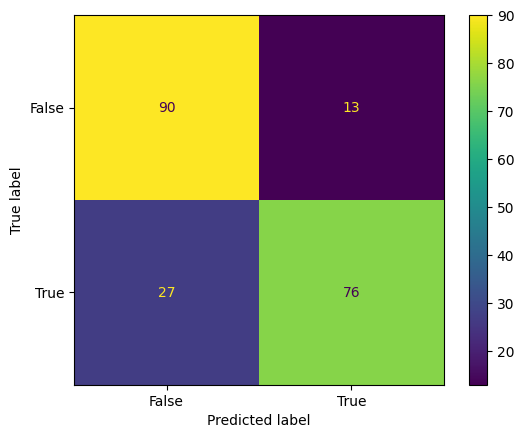

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = [False, True])

cm_display.plot()
plt.show()


## 3.- Time Method

One commonly used metric is the maximum absolute value of the alternant wave. This metric reflects the magnitude of the alternans and provides a quantitative measure of TWA amplitude

### Step 1: Obtain the amplitude for every signal

We have applied the TM to each half of the dictionary, in order to compare the mean amplitude wave and std of each half.

In [ ]:
Valt_TM_est = np.zeros(len(all_filtered))  # Method predictor


# Calculate the number of signals to iterate over (half of the dataset)
half_dataset_size = len(all_filtered) // 2

import itertools

first_half = dict(itertools.islice(all_filtered.items(), 0, half_dataset_size))             # [0,102]
second_half = dict(itertools.islice(all_filtered.items(), half_dataset_size, len(all_filtered)))       # [102, 206]


# Apply temporal method to the first half
for i, (signal_key, signal) in enumerate(first_half.items()):
    X = signal['0']
    Valt_TM_est[i], _ = TimeMethod_TWA(X)


# Apply temporal method to the second half
for i, (signal_key, signal) in enumerate(second_half.items()):
    X = signal['0']
    Valt_TM_est[half_dataset_size + i], _ = TimeMethod_TWA(X)



### Step 2: Calculate mean amplitude and standard deviation for each half of the dataset

In [ ]:
# Calculate mean and std for the first half
mean_1st_half = np.mean(Valt_TM_est[:half_dataset_size])
std_1st_half = np.std(Valt_TM_est[:half_dataset_size])

# Calculate mean and std for the second half
mean_2nd_half = np.mean(Valt_TM_est[half_dataset_size:])
std_2nd_half = np.std(Valt_TM_est[half_dataset_size:])

print("First Half:")
print("Mean Amplitude:", mean_1st_half)
print("Standard Deviation:", std_1st_half)

print("\nSecond Half:")
print("Mean Amplitude:", mean_2nd_half)
print("Standard Deviation:", std_2nd_half)

# Compare mean and std
if mean_1st_half > mean_2nd_half:
    print("\nMean amplitude of the first half is greater:", mean_1st_half )
else:
    print("Mean amplitude of the second half is greater:", mean_2nd_half)

if std_1st_half > std_2nd_half:
    print("Standard deviation of the first half is greater:", std_1st_half)
else:
    print("Standard deviation of the second half is greater:", std_2nd_half)


First Half:
Mean Amplitude: 28.381978473401585
Standard Deviation: 8.303433241748726

Second Half:
Mean Amplitude: 14.909292628297308
Standard Deviation: 8.876967537485074

Mean amplitude of the first half is greater: 28.381978473401585
Standard deviation of the second half is greater: 8.876967537485074


### Step 3: Boxplots

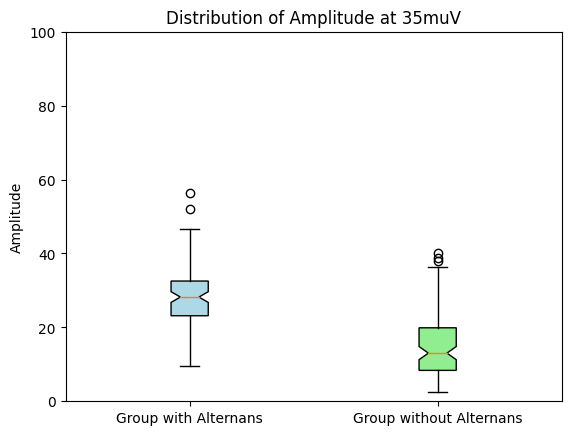

In [ ]:
import matplotlib.pyplot as plt

# Amplitude data for the group with alternans and the group without alternans
group_with_alternans = Valt_TM_est[:half_dataset_size]
group_without_alternans = Valt_TM_est[half_dataset_size:]

# Create a list of data to be plotted
data = [group_with_alternans, group_without_alternans]

# Create a figure and axis
fig, ax = plt.subplots()

# Create the boxplot
boxplot = ax.boxplot(data, patch_artist=True, notch=True)

# Set boxplot colors
colors = ['lightblue', 'lightgreen']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Add labels and title
ax.set_xticklabels(['Group with Alternans', 'Group without Alternans'])
ax.set_ylabel('Amplitude')
plt.title('Distribution of Amplitude at 35muV')

# Show the plot
plt.ylim(0,100)
plt.show()

Thanks for reading up to this point! :)